# <span style='font-family:Futura;font-weight:bold'>NOTEBOOK 4</span>

---

This notebook contains the codes used during the fourth lecture of the course <span style='color:SlateBlue;font-style:italic'>"Modelling from Measurements"</span>.

## <span style='font-family:Futura;font-weight:bold'>Exercise 4.1</span>

Let's consider the Van der Pol oscillator, described by the following equation:

\begin{align}
\ddot{x} - \mu (1 - x^2) \dot{x} + x = 0
\end{align}

The damping term in the equation change the sign according tho the value of the state producing a damping or a pumping. We can obtain a system of first order differential equations by the standard change of variable:

\begin{align}
\dot{x}_1 &= x_2 \\
\dot{x}_2 &= \mu(1 - x_1^2) x_2 - x_1
\end{align}

In [13]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
import sklearn
from sklearn.linear_model import Lasso

plt.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = "Palatino"

In [14]:
dt = 0.01
t = np.linspace(0, 50, 50 / dt) # time discretization
x0 = [0.1, 5] # initial conditions
mu = 1.2 # damping coefficient

In [15]:
def rhs_vdp(x, t, dummy, mu):
    x1, x2 = x
    rhs = [x2,
           mu * (1 - x1 ** 2) * x2 - x1]
    return rhs

In [16]:
x_sol = integrate.odeint(rhs_vdp, x0, t, args=([], mu), mxstep=10**8) # integrate PDE

<IPython.core.display.Javascript object>


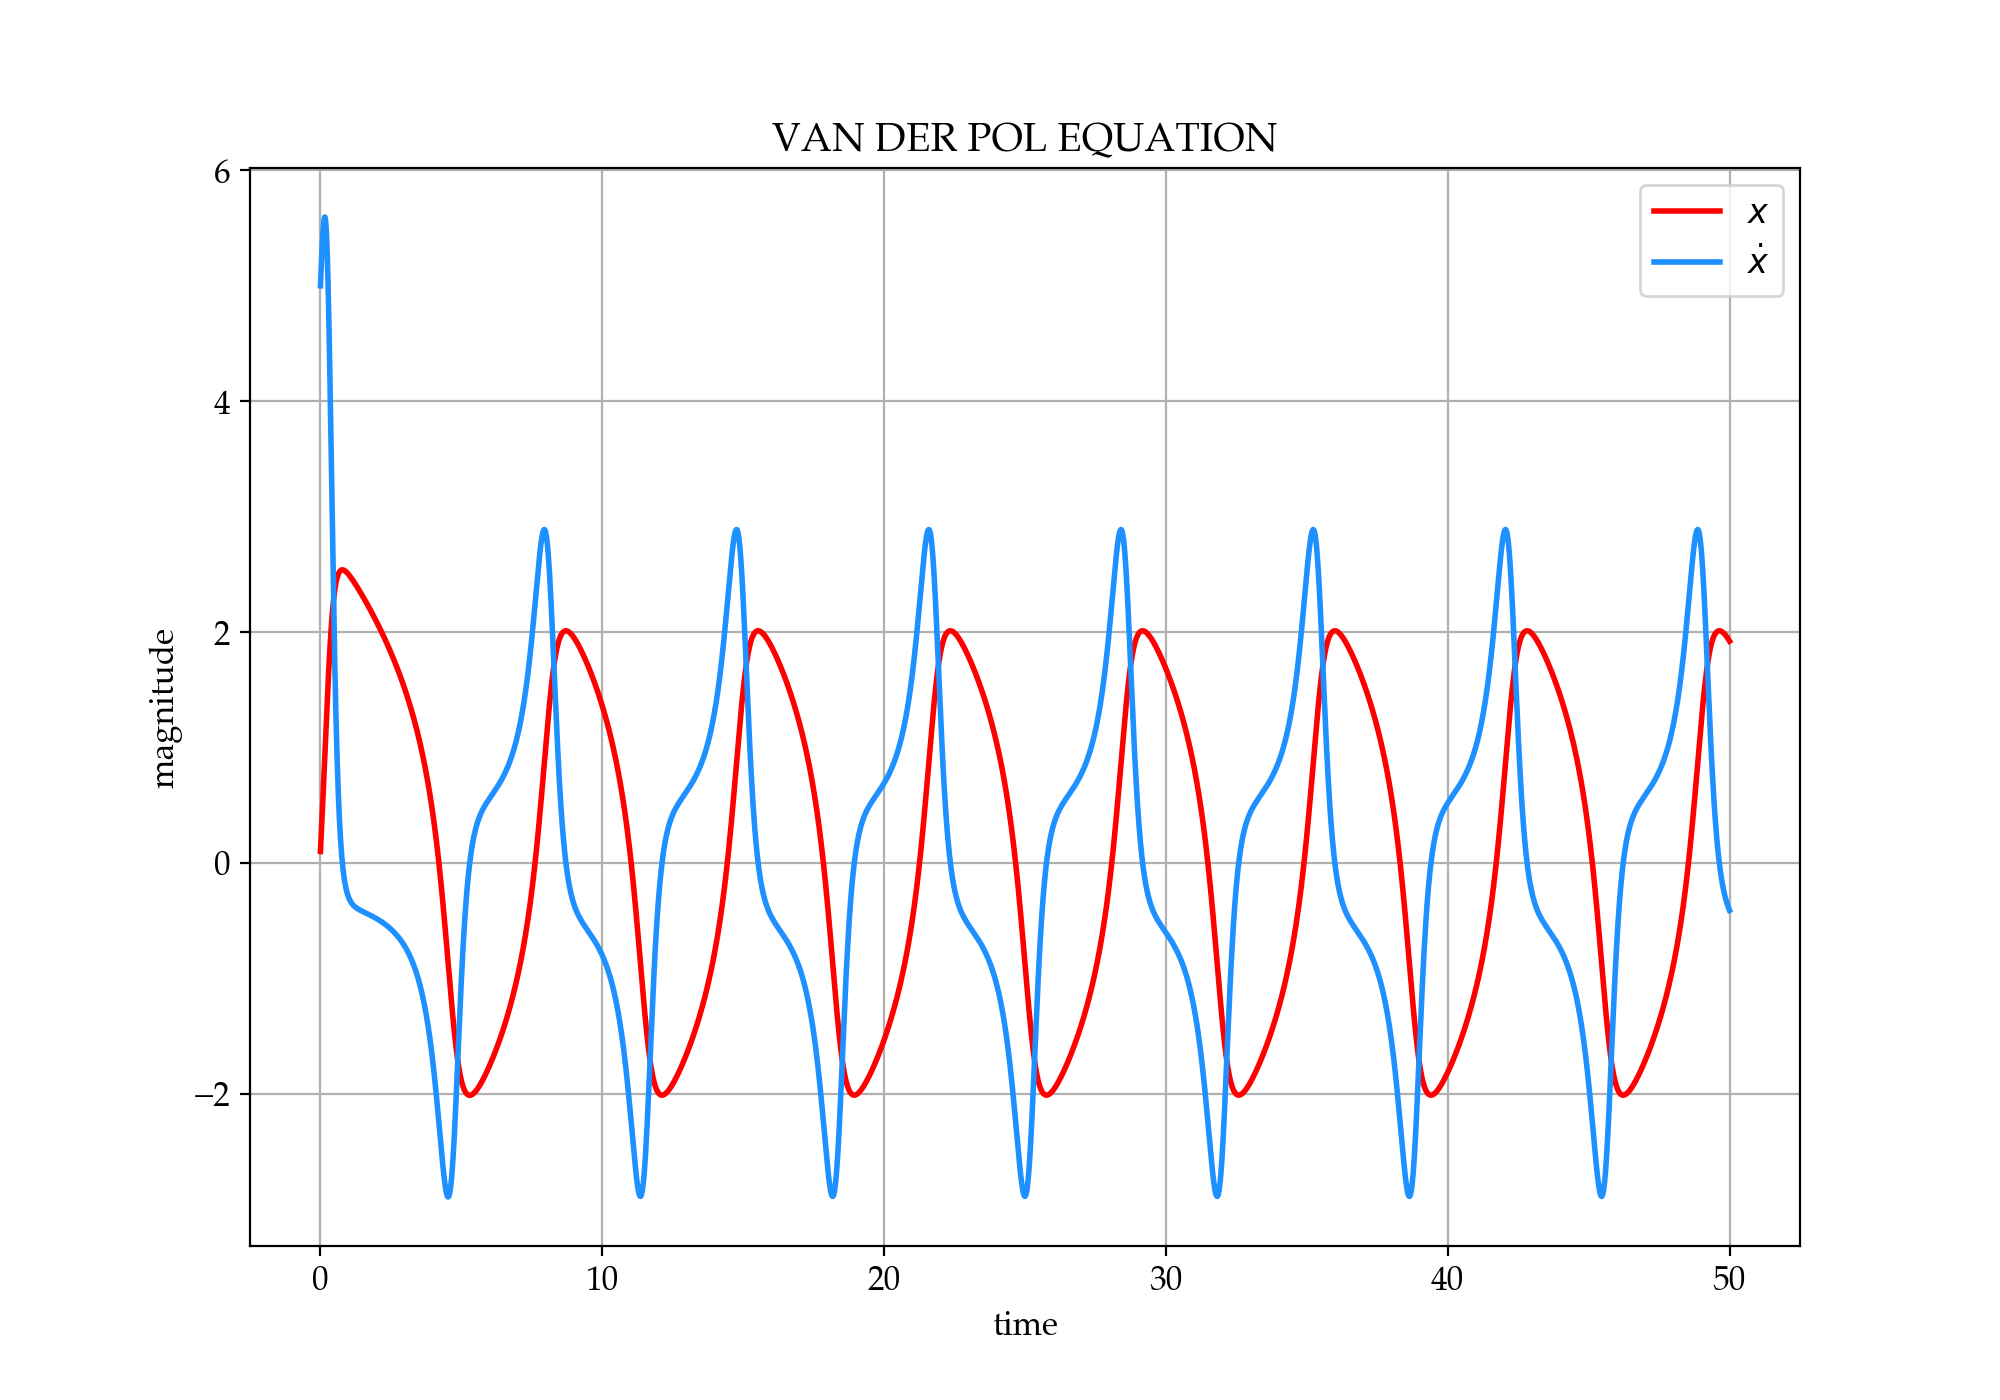

Text(0.5, 1.0, 'VAN DER POL EQUATION')

In [17]:
fig = plt.figure(figsize=(10, 7))
plt.plot(t, x_sol[:,0], color='r', linewidth=2)
plt.plot(t, x_sol[:,1], color='dodgerblue', linewidth=2)
plt.grid()
plt.ylabel('magnitude')
plt.xlabel('time')
plt.legend([r'$x$', r'$\dot{x}$'])
plt.title('VAN DER POL EQUATION')

The model above is the ground truth. What we wanna do now is sample from the model and try to recover the differential equations that govern it. We will use centered difference even if they are not so accurate..

In [18]:
n = len(t)

noise = 0.

x1 = x_sol[:, 0] + noise * np.random.randn(n,)
x2 = x_sol[:, 1] + noise * np.random.randn(n,)

x1dot = [0] * (n - 2)
x2dot = [0] * (n - 2)

# center difference scheme
for i in range(1, n-1):
    x1dot[i-1] = (x1[i+1] - x1[i-1]) / (2 * dt)
    x2dot[i-1] = (x2[i+1] - x2[i-1]) / (2 * dt)
    
x1s = np.array(x1[1:-1])
x2s = np.array(x2[1:-1])

#A = np.array([x1s, x2s, x1s ** 2, x1s * x2s, x2s ** 2, x1s ** 3, (x2s ** 2) * x1s, x2s ** 3])
A = np.array([x1s, x2s, x1s ** 2, x1s * x2s, x2s ** 2, x1s ** 3, (x1s ** 2) * x2s, (x2s ** 2) * x1s, x2s ** 3])

In [19]:
model1 = Lasso(alpha=0.1)
model1.fit(A.T, x1dot)
model2 = Lasso(alpha=0.1)
model2.fit(A.T, x2dot)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

<IPython.core.display.Javascript object>


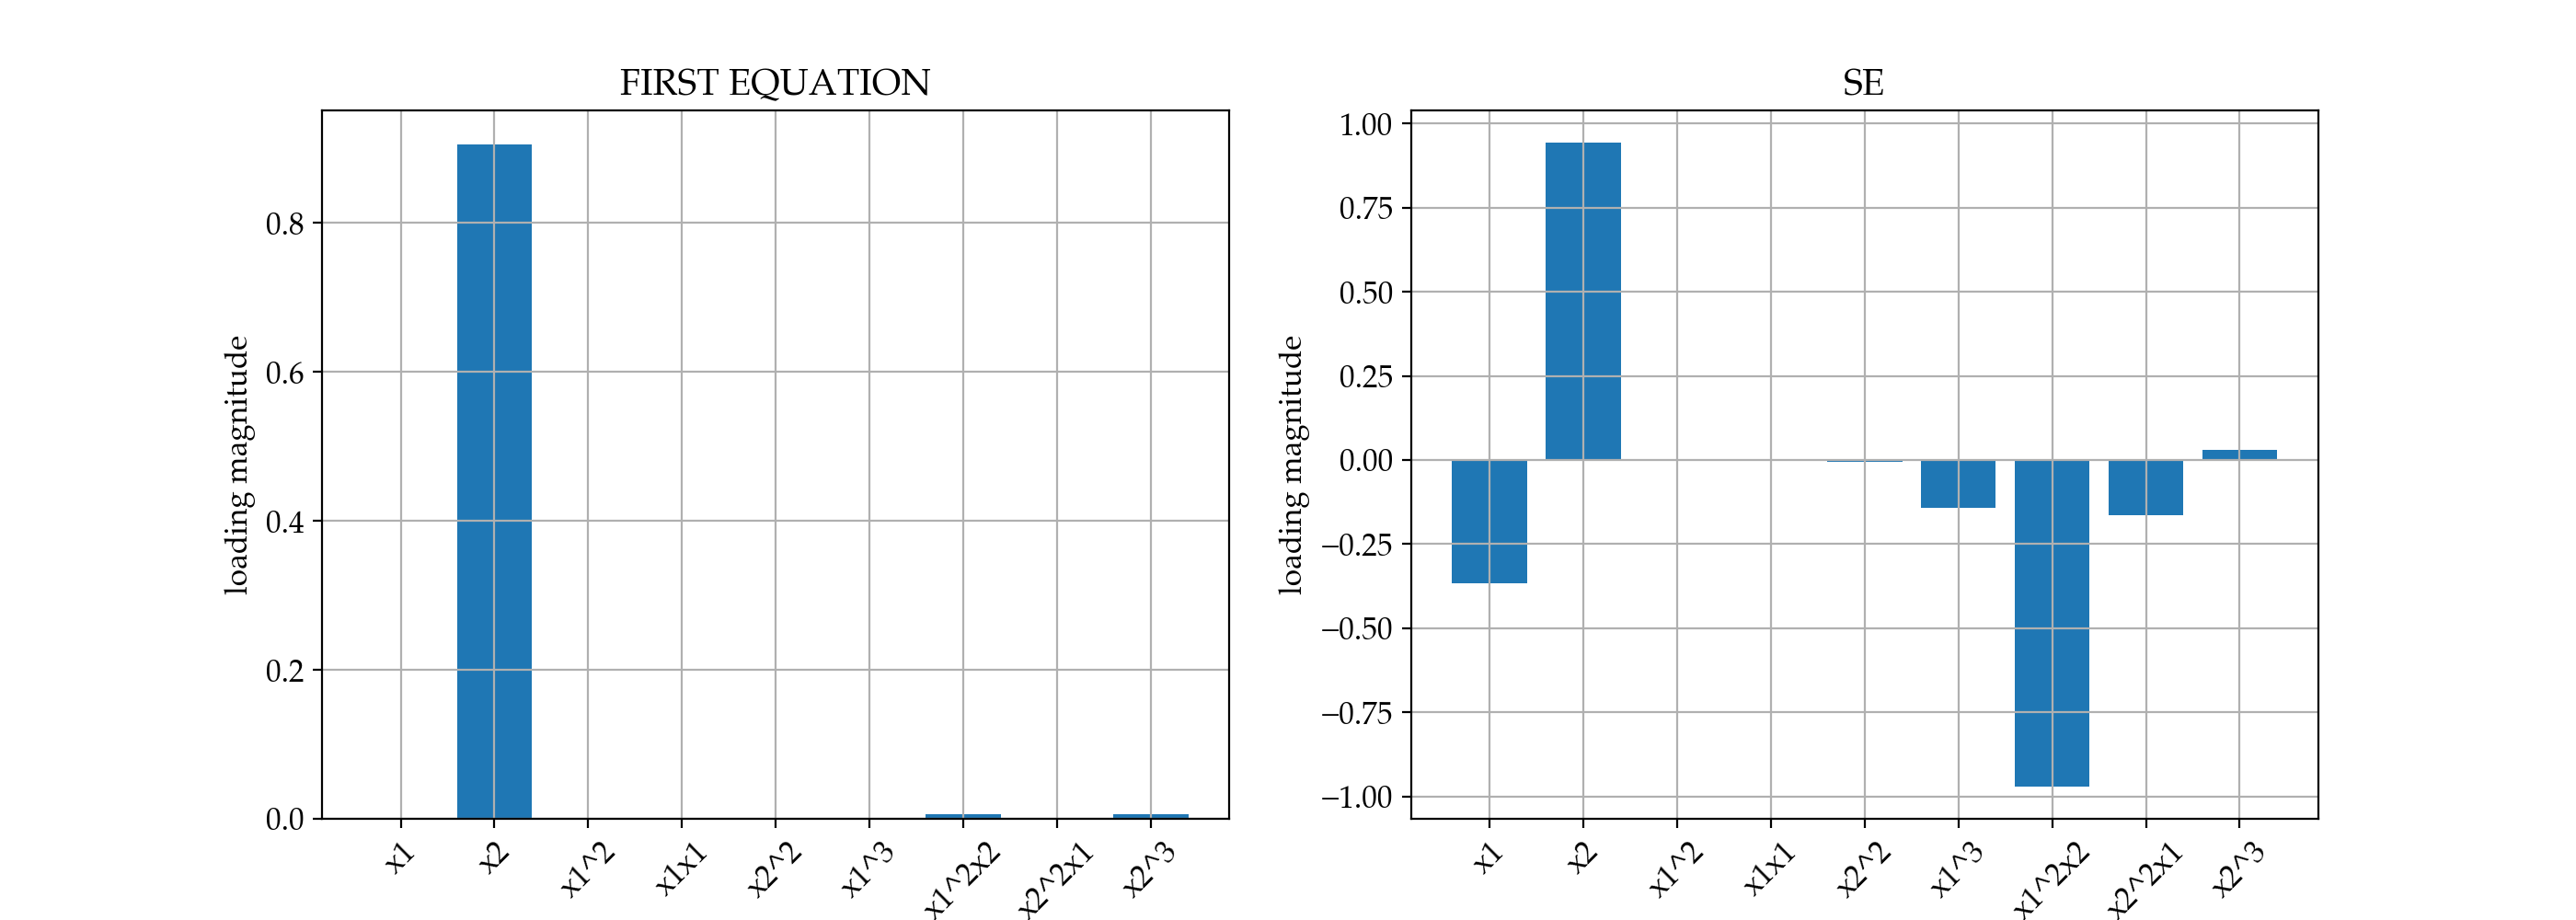

In [20]:
fig = plt.figure(figsize=(14, 5))
ax = [fig.add_subplot(1, 2, k) for k in range(1,3)]
#bar_name = ['0','x1', 'x2', 'x1^2', 'x1x1', 'x2^2', 'x1^3', 'x2^2x1', 'x2^3']
bar_name = ['x1', 'x2', 'x1^2', 'x1x1', 'x2^2', 'x1^3', 'x1^2x2', 'x2^2x1', 'x2^3']
ax[0].bar(bar_name, model1.coef_)
ax[1].bar(bar_name, model2.coef_)
ax[0].grid()
ax[1].grid()
ax[0].set_title('FIRST EQUATION')
ax[1].set_title('SE')
ax[0].set_ylabel('loading magnitude')
ax[1].set_ylabel('loading magnitude')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

At this point we can try the time delay embedding

<IPython.core.display.Javascript object>


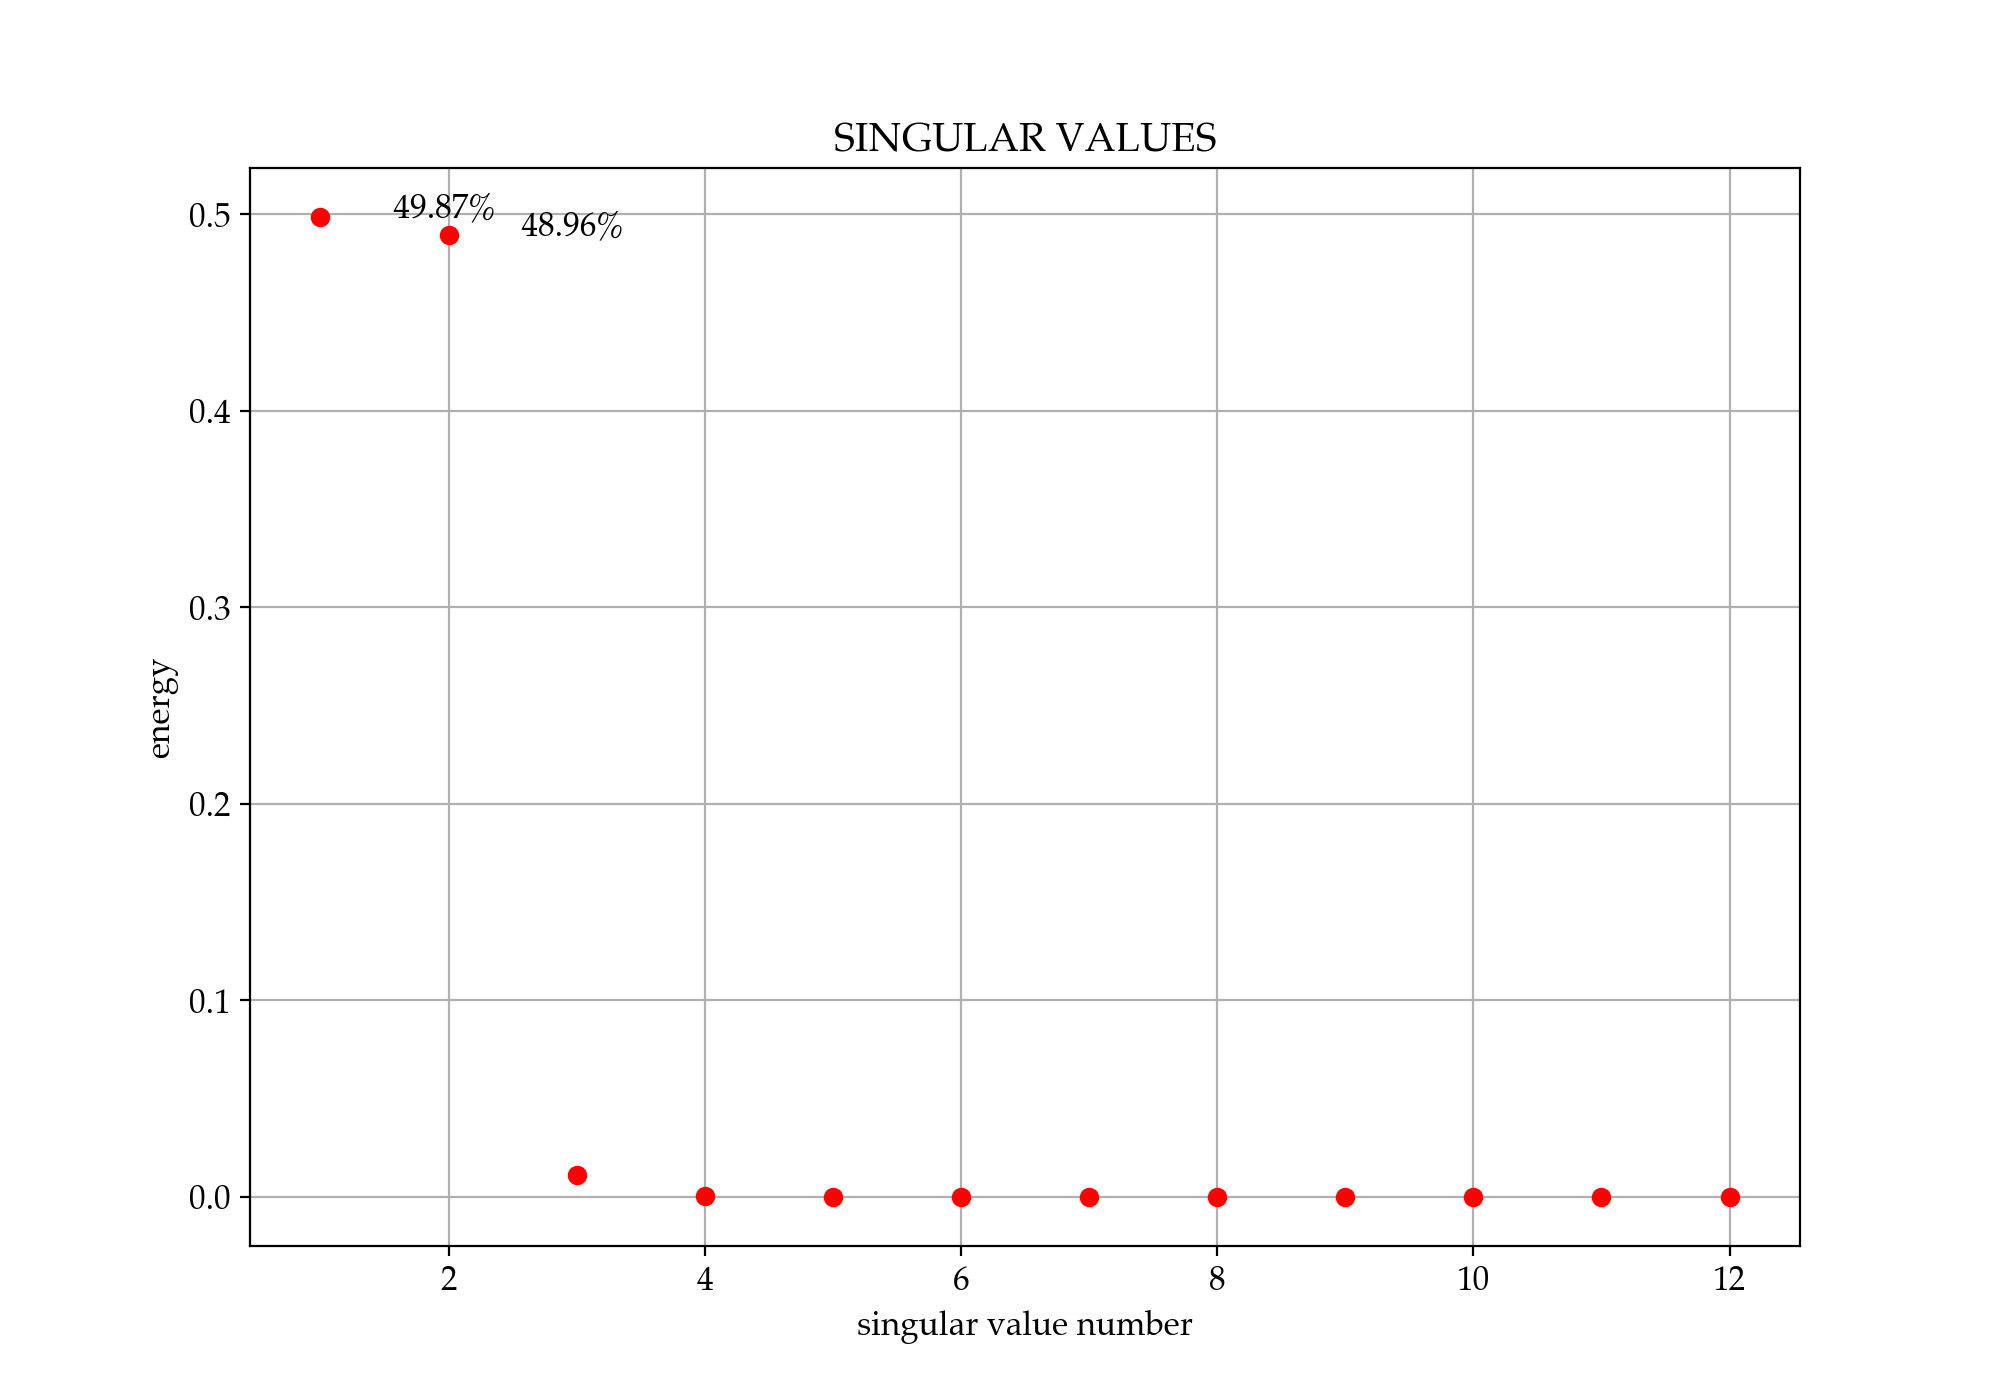

Text(0.5, 1.0, 'SINGULAR VALUES')

In [41]:
H = x_sol[0:4000, :].T # initialize Hankel matrix
time_embedding = 6

for i in range(1, time_embedding):
    H = np.vstack((H, x_sol[i:4000+i, :].T))
    
U, S, V = np.linalg.svd(H, full_matrices=False)
V = V.T

fig = plt.figure(figsize=(10, 7))
plt.plot(range(1, len(S)+1), S / np.sum(S), 'ro')
plt.text(1.5, S[0] / np.sum(S), '{:6.2f}'.format(S[0] / np.sum(S) * 100) + '%')
plt.text(2.5, S[1] / np.sum(S), '{:6.2f}'.format(S[1] / np.sum(S) * 100) + '%')
plt.grid()
plt.ylabel('energy')
plt.xlabel('singular value number')
plt.title('SINGULAR VALUES')

<IPython.core.display.Javascript object>


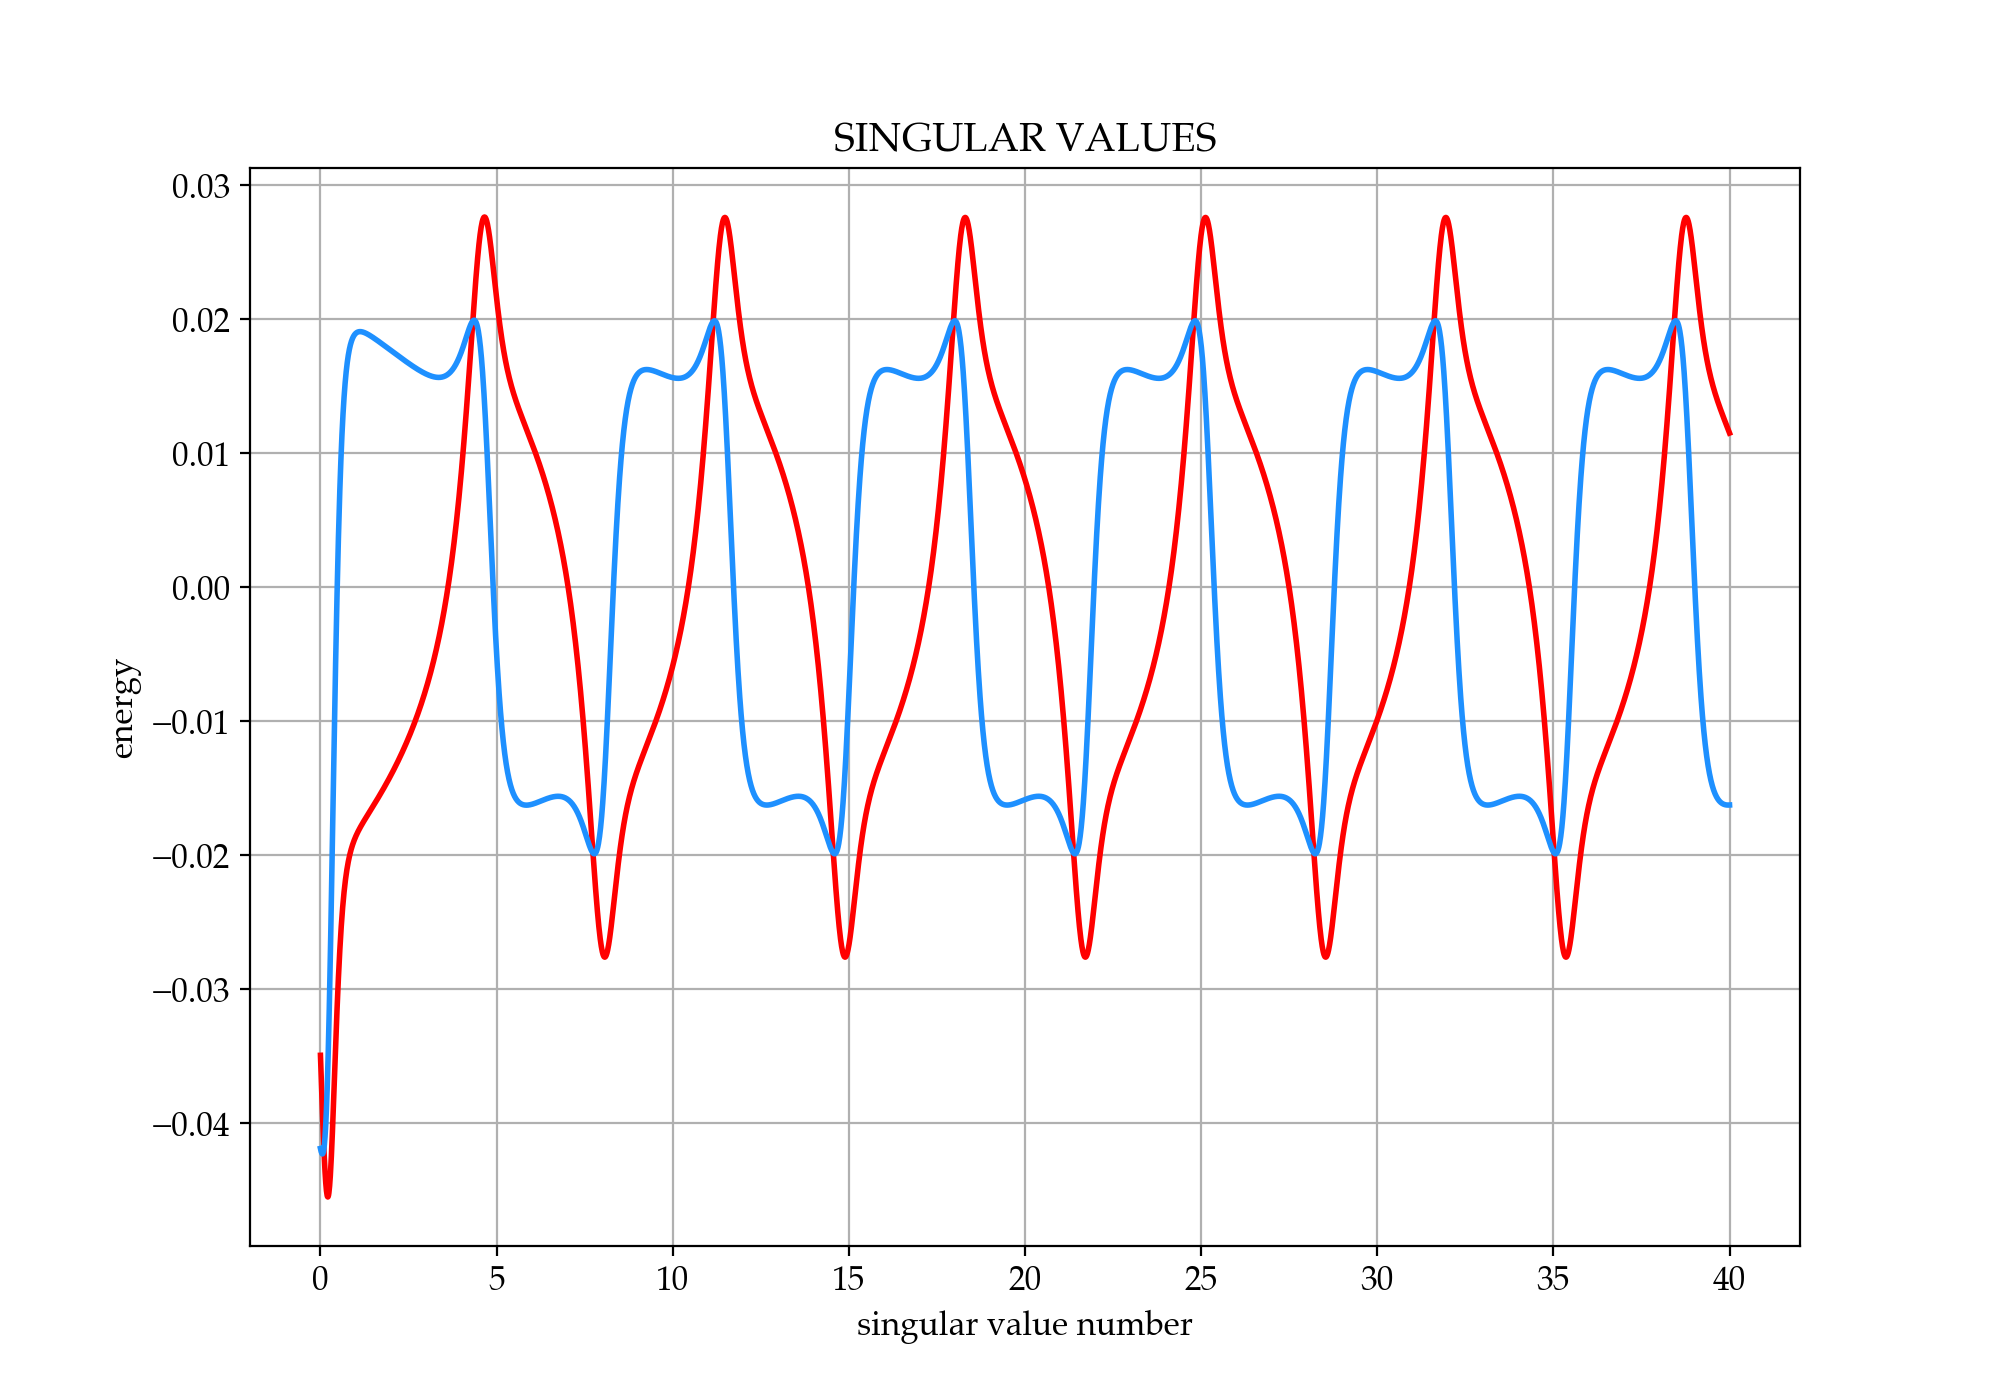

Text(0.5, 1.0, 'SINGULAR VALUES')

In [44]:
fig = plt.figure(figsize=(10, 7))
plt.plot(t[0:4000], V[:, 0], color='r', linewidth=2)
plt.plot(t[0:4000], V[:, 1], color='dodgerblue', linewidth=2)
plt.grid()
plt.ylabel('energy')
plt.xlabel('singular value number')
plt.title('SINGULAR VALUES')

<IPython.core.display.Javascript object>


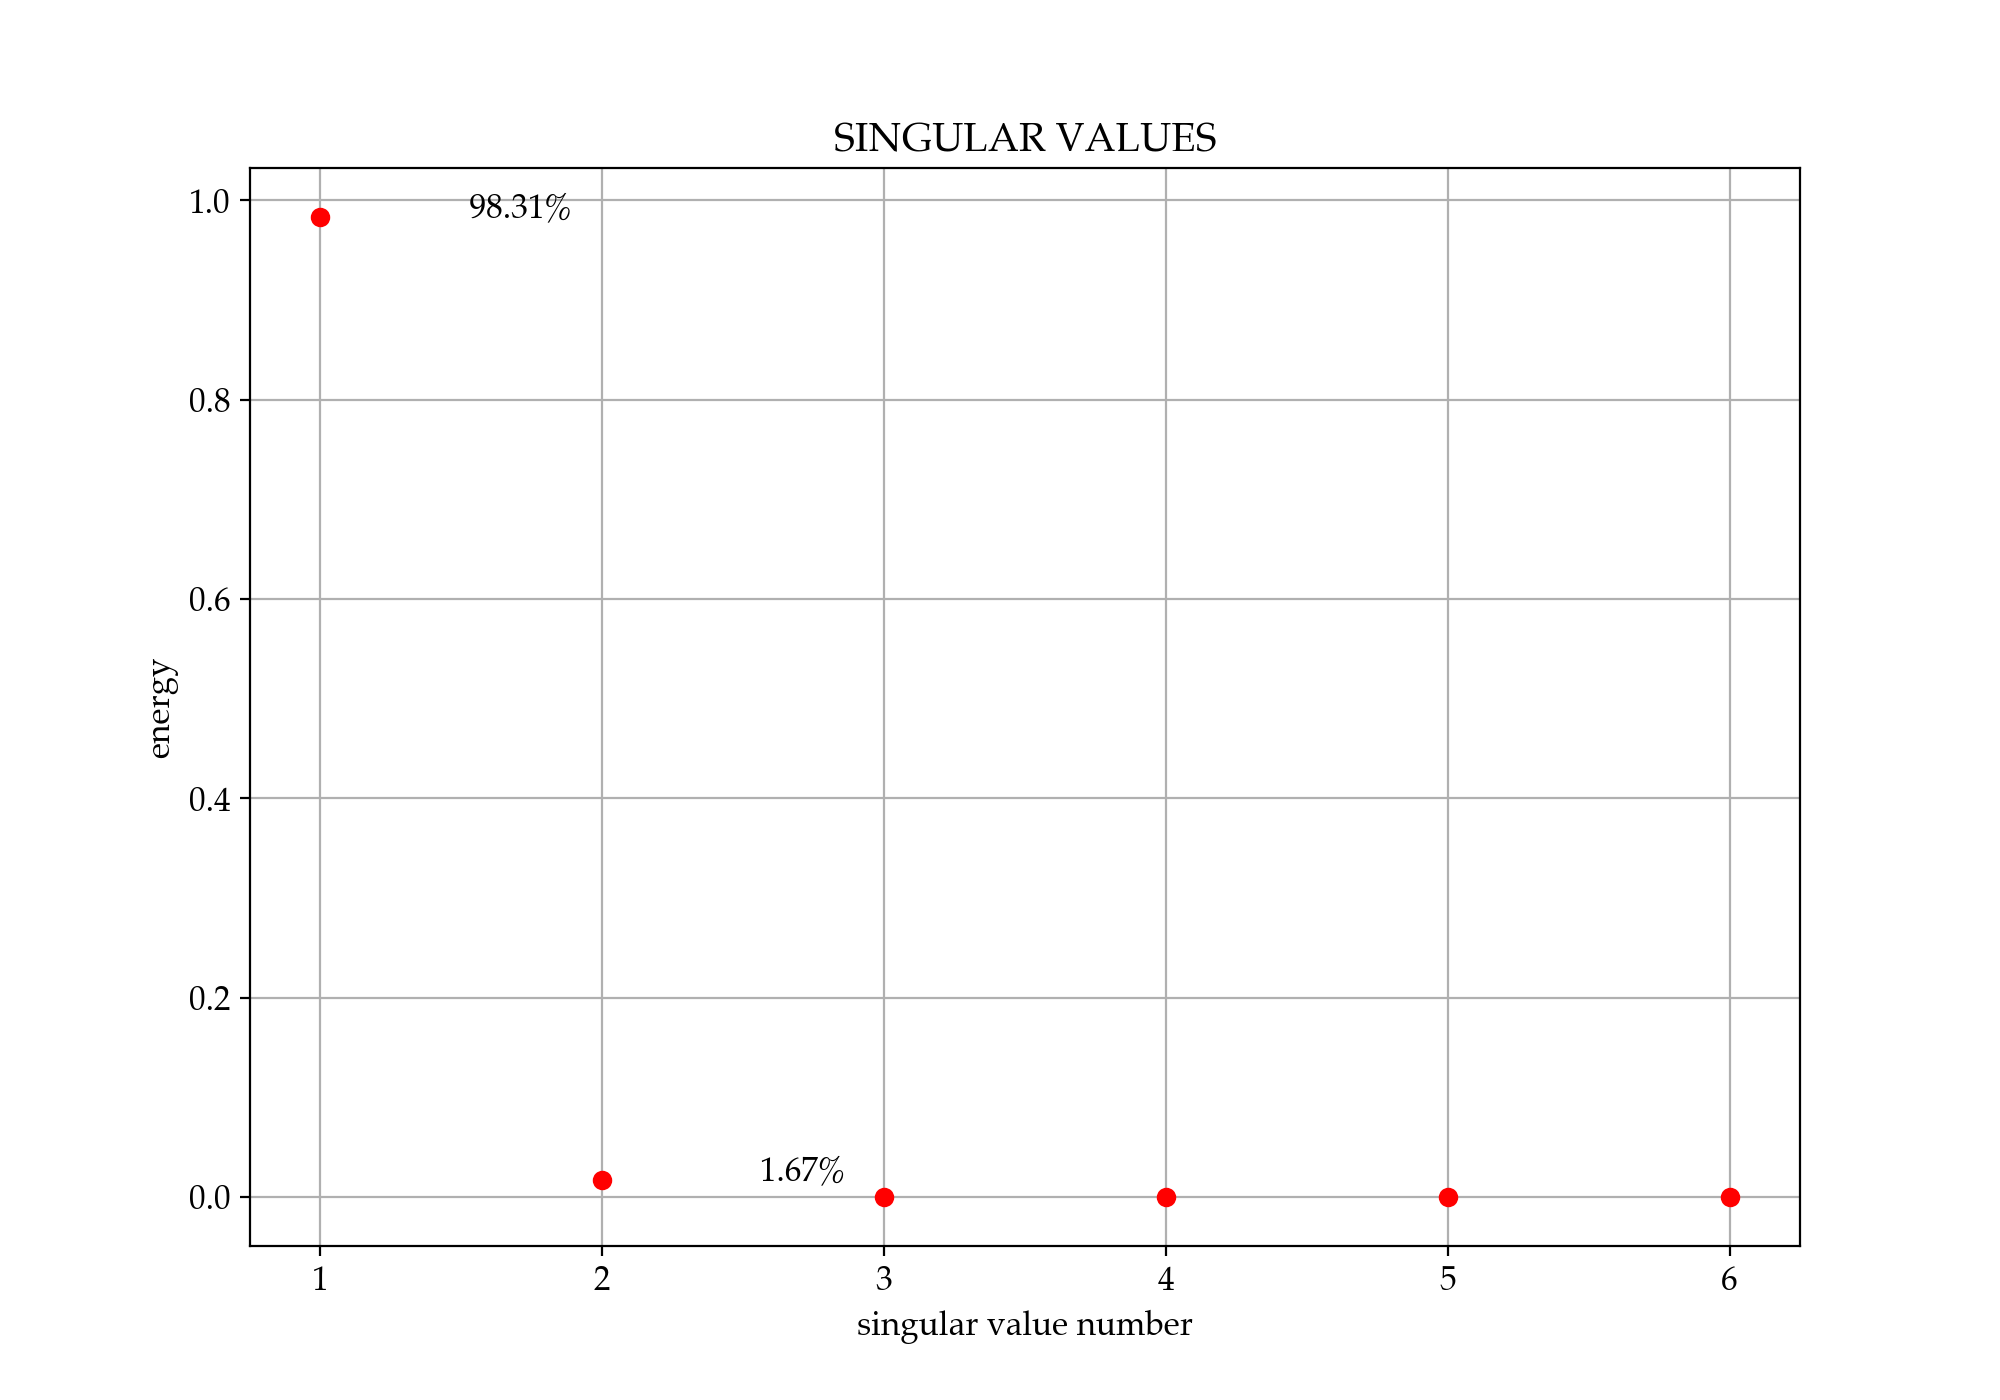

Text(0.5, 1.0, 'SINGULAR VALUES')

In [45]:
H = x_sol[0:4000, 0].T # initialize Hankel matrix
time_embedding = 6

for i in range(1, time_embedding):
    H = np.vstack((H, x_sol[i:4000+i, 0].T))
    
U, S, V = np.linalg.svd(H, full_matrices=False)
V = V.T

fig = plt.figure(figsize=(10, 7))
plt.plot(range(1, len(S)+1), S / np.sum(S), 'ro')
plt.text(1.5, S[0] / np.sum(S), '{:6.2f}'.format(S[0] / np.sum(S) * 100) + '%')
plt.text(2.5, S[1] / np.sum(S), '{:6.2f}'.format(S[1] / np.sum(S) * 100) + '%')
plt.grid()
plt.ylabel('energy')
plt.xlabel('singular value number')
plt.title('SINGULAR VALUES')

<IPython.core.display.Javascript object>


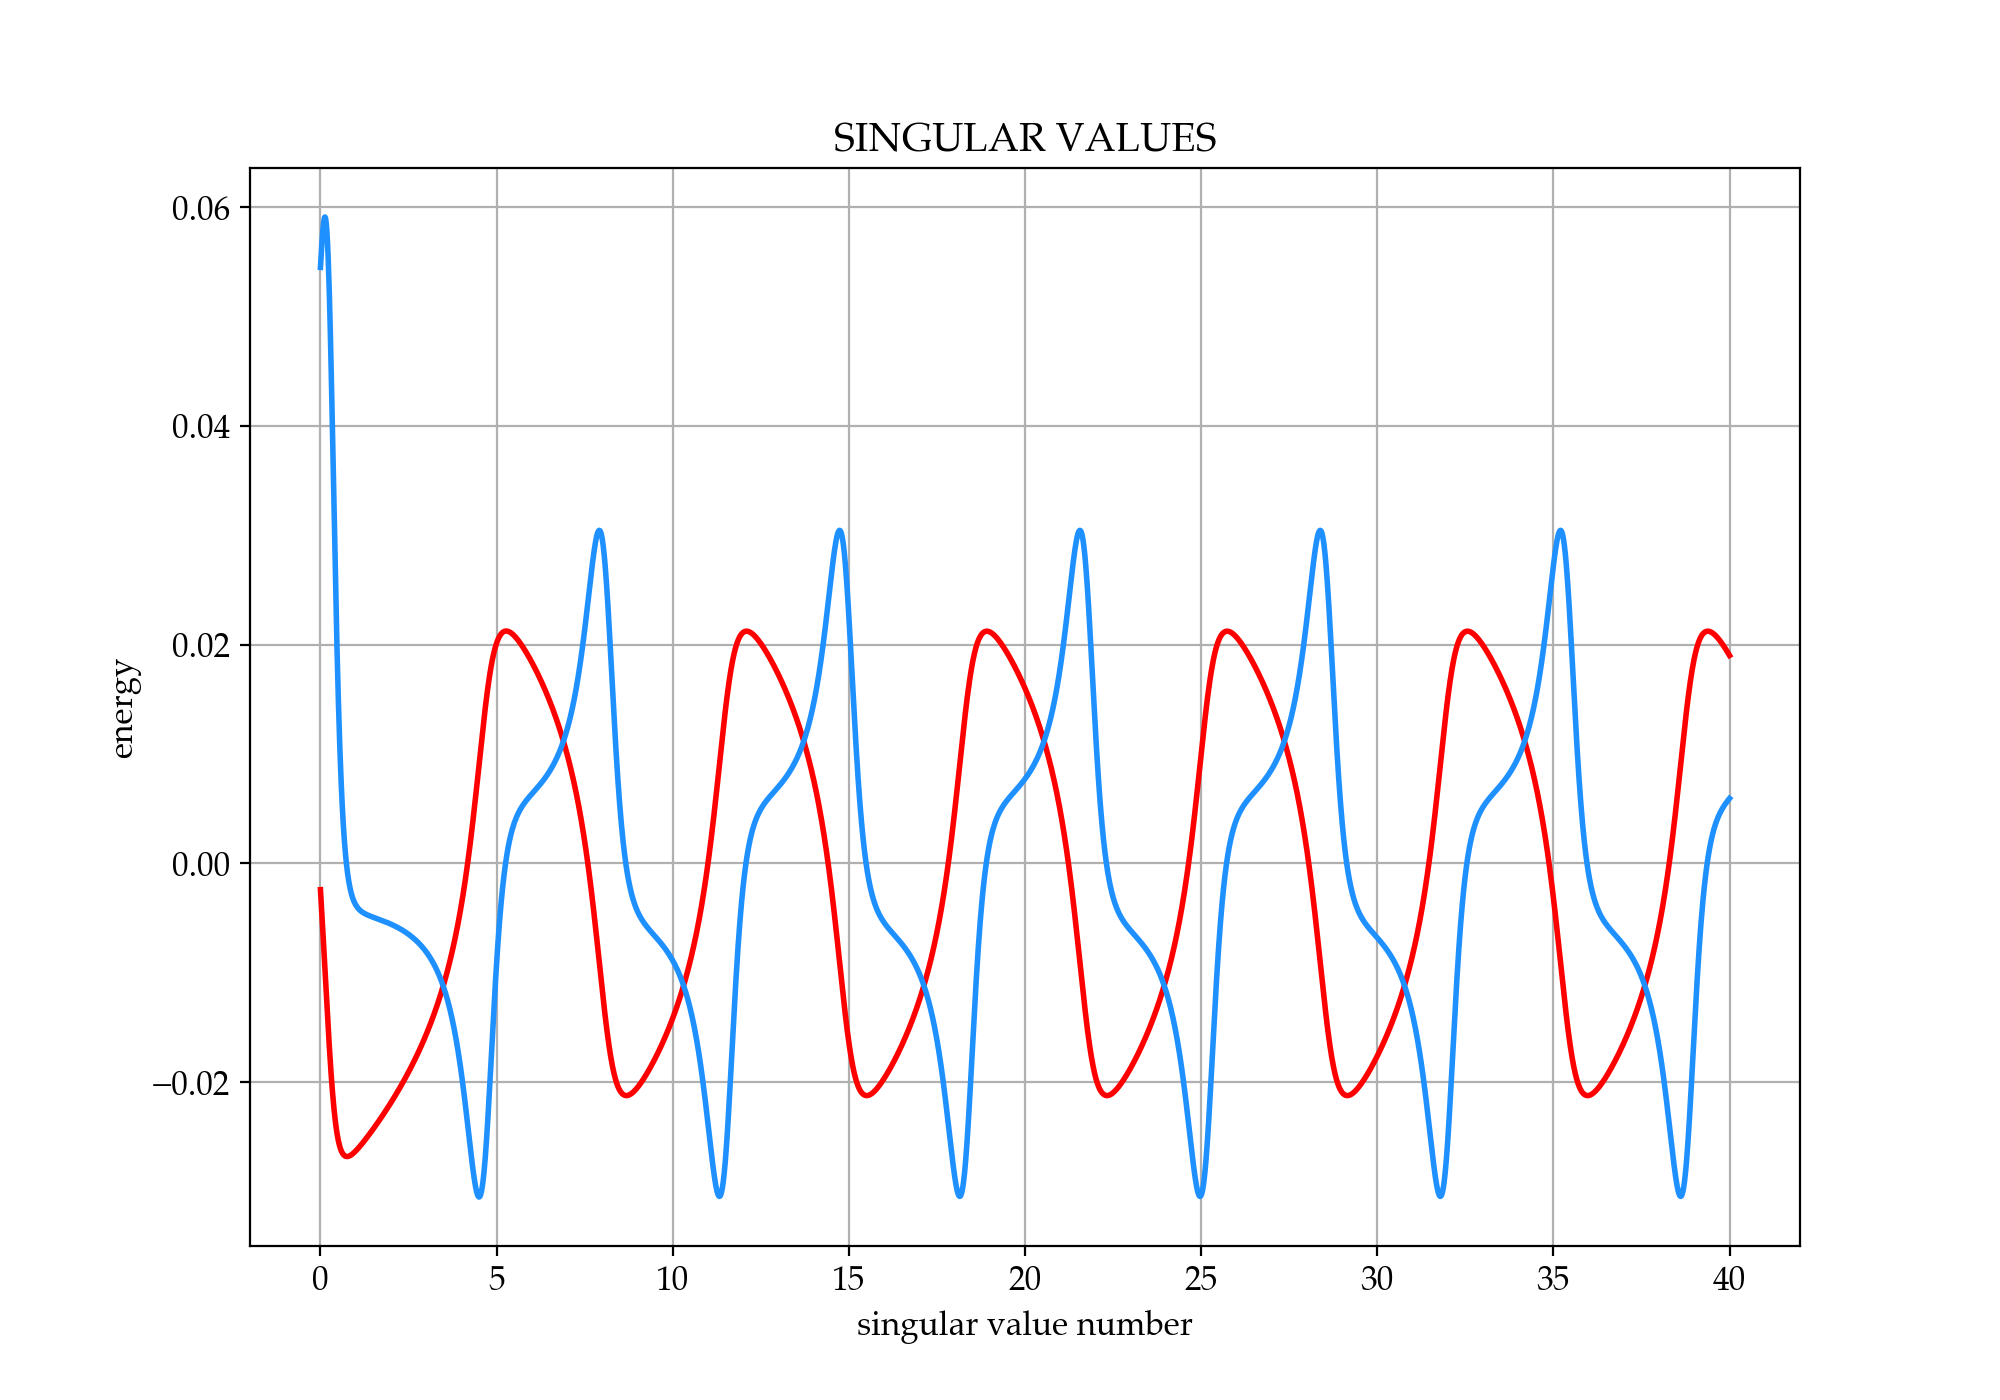

Text(0.5, 1.0, 'SINGULAR VALUES')

In [46]:
fig = plt.figure(figsize=(10, 7))
plt.plot(t[0:4000], V[:, 0], color='r', linewidth=2)
plt.plot(t[0:4000], V[:, 1], color='dodgerblue', linewidth=2)
plt.grid()
plt.ylabel('energy')
plt.xlabel('singular value number')
plt.title('SINGULAR VALUES')